In [13]:

import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload
from astropy.io import fits
import copy
import time
from datetime import timezone 

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize, CenteredNorm
from matplotlib.patches import Circle, Rectangle
from matplotlib.gridspec import GridSpec

import esc_llowfsc_sim
from lina.math_module import xp, xcipy, ensure_np_array
from lina import utils, dm, efc, pwp, shmim_utils, coro_utils
import lina.control_models as cmods

from magpyx.utils import ImageStream

model_params = utils.load_pickle(esc_llowfsc_sim.path/'data/example_fraunhofer_params_1K.pkl')
wfe_data = utils.load_pickle(esc_llowfsc_sim.path/'data/prefpm_wfe_data_1K.pkl')



4.644451063497162e-06


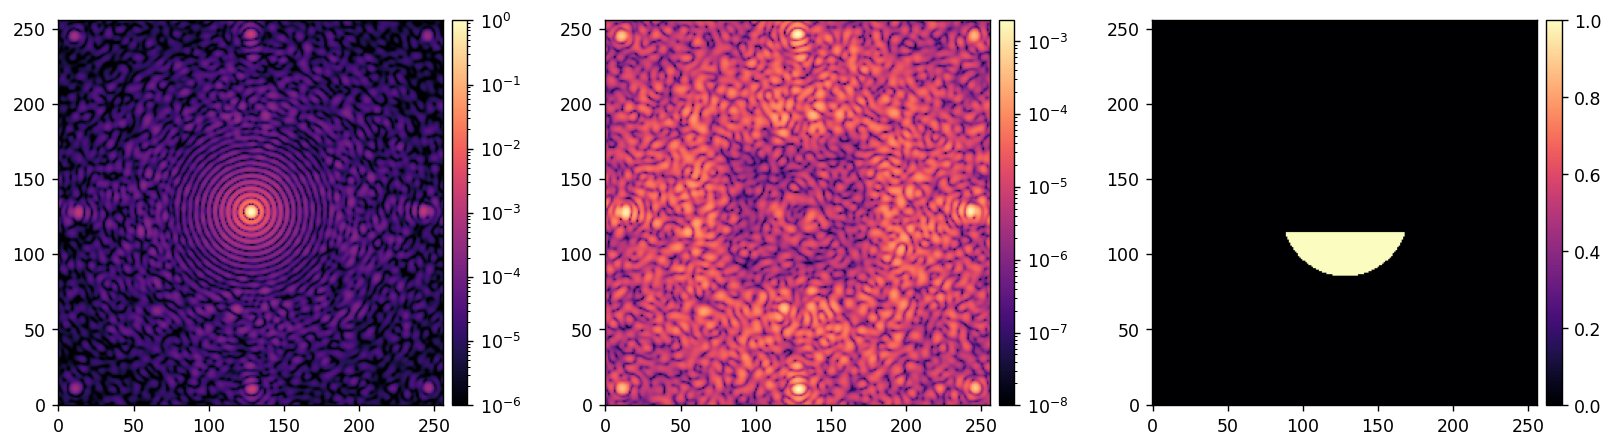

In [14]:
reload(cmods)
M = cmods.MODEL(
    wavelength_c=475e-9,
    wavelength=475e-9, 
    npix=500,
    Ndef=502,
    N_vortex_lres = 2048,
    vortex_win_diam = 25, # diameter of the Tukey window in lambda/D to apply for the vortex model 
    vortex_hres_sampling = 0.05, # lam/D per pixel; this value is chosen empirically
    vortex_dot_mask_diam_lamDc = 0.85,
    # fsm_beam_diam = 12e-3,
    dm_beam_diam = 9.3e-3,
    lyot_beam_diam=4e-3,
    lyot_diam=3.6e-3,
    camsci_pxscl_lamDc=0.239,
    ncamsci=256,
    Nact=34,
    act_spacing=300e-6,
    act_coupling=0.15,
    PREFPM_AMP=wfe_data['PREFPM_AMP'],
    # PREFPM_OPD=wfe_data['PREFPM_OPD'],
    PREFPM_OPD=wfe_data['FLATTENED_OPD'],
)

actuators = np.zeros(M.Nacts)
ref_psf = xp.abs(M.forward(actuators, wavelength=475e-9, use_vortex=False))**2
M.Imax_ref = xp.max(ref_psf)
coro_im = xp.abs(M.forward(actuators, wavelength=475e-9,))**2

iwa = 3
owa = 10

dm_mask = dm.create_mask(Nact=34, return_np=1)

dh_mask = utils.create_annular_focal_plane_mask(
    M.ncamsci,
    M.camsci_pxscl_lamDc,
    iwa, 
    owa,  
    edge=iwa,
    centering='odd', # odd or even
    rotation=90,
    x_shift=0,
    y_shift=0,
    return_np=1,
)

model_based_contrast = xp.mean(coro_im[xp.array(dh_mask)])
print(model_based_contrast)
utils.imshow(
    [ref_psf/M.Imax_ref, coro_im, dh_mask],
    norms=[LogNorm(1e-6), LogNorm(1e-8)],
)

In [16]:
reload(efc)
jac = efc.compute_jacobian(
    M,
    dh_mask,
    amp=1e-9, 
)

# Create the probes and obtain reference images form the instrument. 

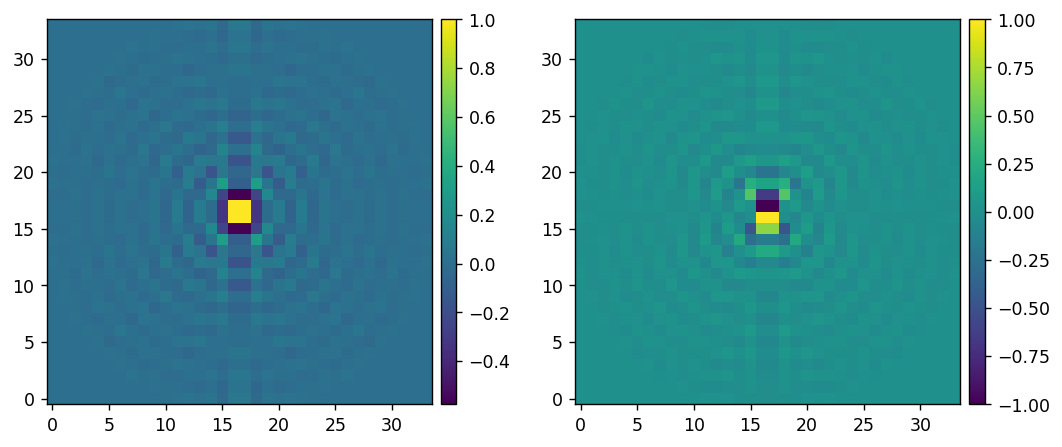

In [4]:
reload(utils)
reload(dm)
fourier_probes = dm.create_fourier_probes(
    M.dm_mask, 
    M.ncamsci, 
    M.camsci_pxscl_lamDc, 
    2,
    14, 
    rotation=90,
    use_weighting=True,
    nprobes=2,
    return_np=1, 
)

utils.imshow([fourier_probes[0], fourier_probes[1]], cmaps=3*['viridis'])

In [5]:
CAMSCI_STREAM = ImageStream('camscisim')
CAMSCI_STREAM = ImageStream('camscisim')
CAMSCI_SHUTTER_STREAM = ImageStream('camscishutter')
CAMSCI_EXPTIME_STREAM = ImageStream('camsciexptime')
CAMSCI_GAIN_STREAM = ImageStream('camscigain')
DM2_STREAM = ImageStream('dm00disp02')
FSM1_STREAM = ImageStream('fsm01')
FSM2_STREAM = ImageStream('fsm02')


INFO:utils:Got semaphore index 0.


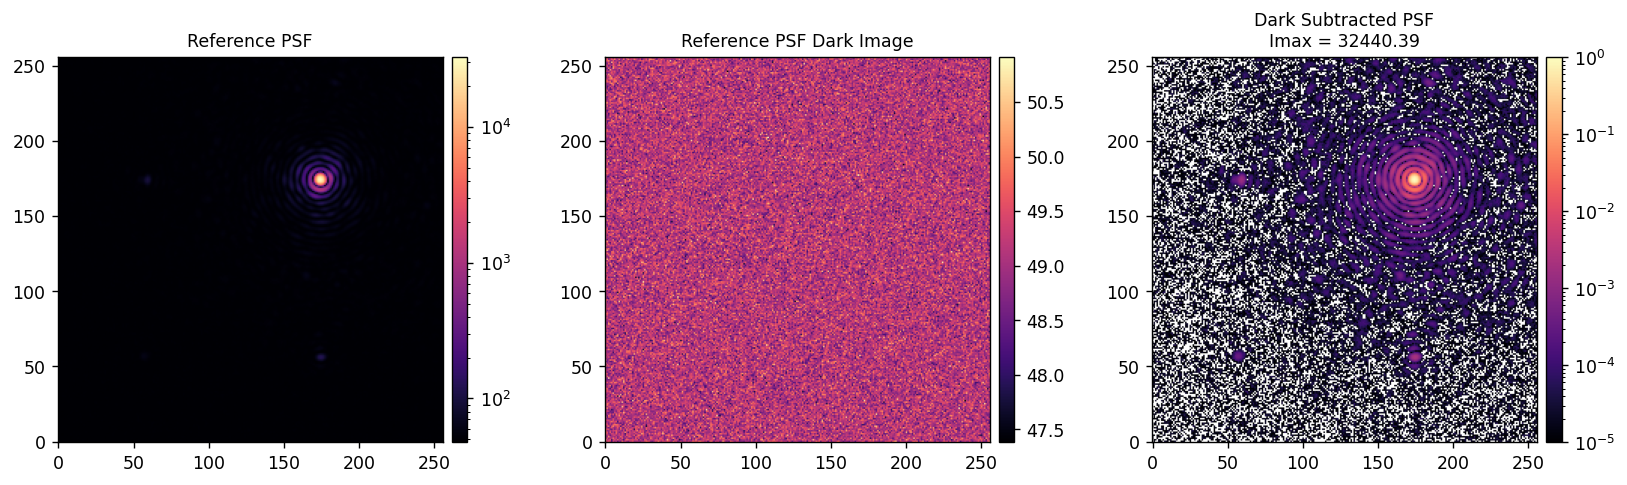

In [6]:
ref_psf_exp_time, ref_psf_gain = (0.001, 0)

shmim_utils.write(CAMSCI_SHUTTER_STREAM, [0])
shmim_utils.write(CAMSCI_EXPTIME_STREAM, [ref_psf_exp_time])
shmim_utils.write(CAMSCI_GAIN_STREAM, [ref_psf_gain])

shmim_utils.write(FSM1_STREAM, [0, 50, 50])

shmim_utils.write(CAMSCI_SHUTTER_STREAM, [1])
time.sleep(0.5)
ref_psf_dark = shmim_utils.stack(CAMSCI_STREAM, 100)
shmim_utils.write(CAMSCI_SHUTTER_STREAM, [0])

ref_psf = shmim_utils.stack(CAMSCI_STREAM, 100)
ref_psf_ds = ref_psf - ref_psf_dark

ref_params = {
    'Imax':xp.max(ref_psf_ds),
    'exp_time':ref_psf_exp_time,
    'gain':ref_psf_gain, 
}

shmim_utils.write(FSM1_STREAM, [0, 0, 0])

utils.imshow(
    [ref_psf, ref_psf_dark, ref_psf_ds/ref_params['Imax']],
    titles=['Reference PSF', 'Reference PSF Dark Image', f'Dark Subtracted PSF\nImax = {ref_params["Imax"]:.2f}'],
    norms=[LogNorm(), None, LogNorm(1e-5)],
)

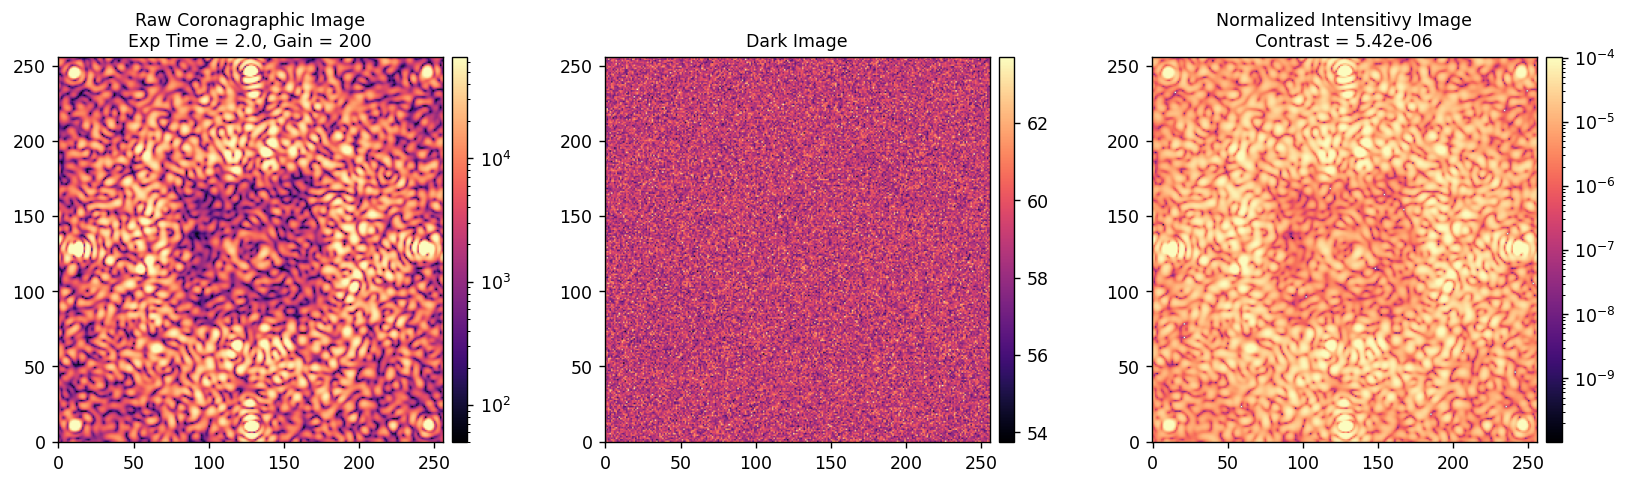

In [7]:

coro_im_params = {
    'exp_time':2.0,
    'gain':200,
}

shmim_utils.write(CAMSCI_EXPTIME_STREAM, [coro_im_params['exp_time']])
shmim_utils.write(CAMSCI_GAIN_STREAM, [coro_im_params['gain']])

shmim_utils.write(CAMSCI_SHUTTER_STREAM, [1])
time.sleep(0.5)
coro_dark = shmim_utils.stack(CAMSCI_STREAM, 200)
shmim_utils.write(CAMSCI_SHUTTER_STREAM, [0])

coro_im = shmim_utils.stack(CAMSCI_STREAM, 10)
coro_im_ni0 = coro_utils.normalize_coro_im(coro_im, coro_im_params, ref_params, coro_dark)

contrast0 = coro_utils.compute_contrast(coro_im_ni0, dh_mask)

utils.imshow(
    [coro_im, coro_dark, coro_im_ni0],
    titles=[
        f'Raw Coronagraphic Image\nExp Time = {coro_im_params["exp_time"]}, Gain = {coro_im_params["gain"]}', 
        f'Dark Image',
        f'Normalized Intensitivy Image\nContrast = {contrast0:.2e}',
    ],
    norms=[LogNorm(), None, LogNorm()],
)

In [15]:
DM2_STREAM.write(np.zeros_like(dm_mask))

In [ ]:
E_est_vec.shape

(1719,)

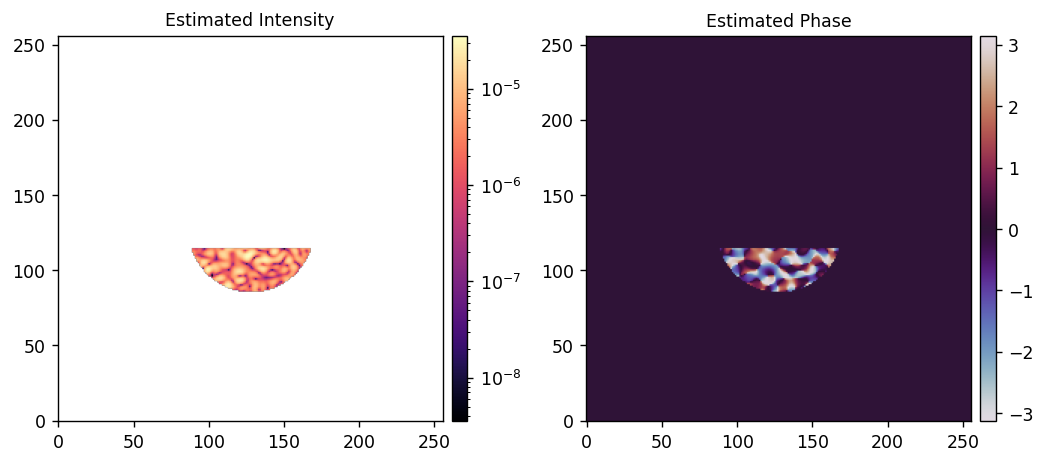

In [8]:
reload(pwp)

current_command = DM2_STREAM.grab_latest() / 1e6
current_acts = current_command[dm_mask]

# E_est, E_est_vec = pwp.run_with_jacobian(
#     CAMSCI_STREAM,
#     DM2_STREAM,
#     coro_im_params,
#     ref_params,
#     jac,
#     20, 
#     dh_mask, 
#     dm_mask,
#     fourier_probes, 
#     5e-9,
#     reg_cond=1e-2, 
#     gain=1,
#     # plot=1,
#     plot_est=1,
#     delay=0.05,
# )

E_est, E_est_vec = pwp.run(
    CAMSCI_STREAM,
    DM2_STREAM,
    coro_im_params,
    ref_params,
    50, 
    dh_mask, 
    dm_mask,
    fourier_probes, 
    5e-9,
    jacobian=jac,
    M=None, 
    E_FP_NOM=None,
    reg_cond=1e-4, 
    gain=1,
    # plot=1,
    plot_est=1,
    delay=0.05,
)

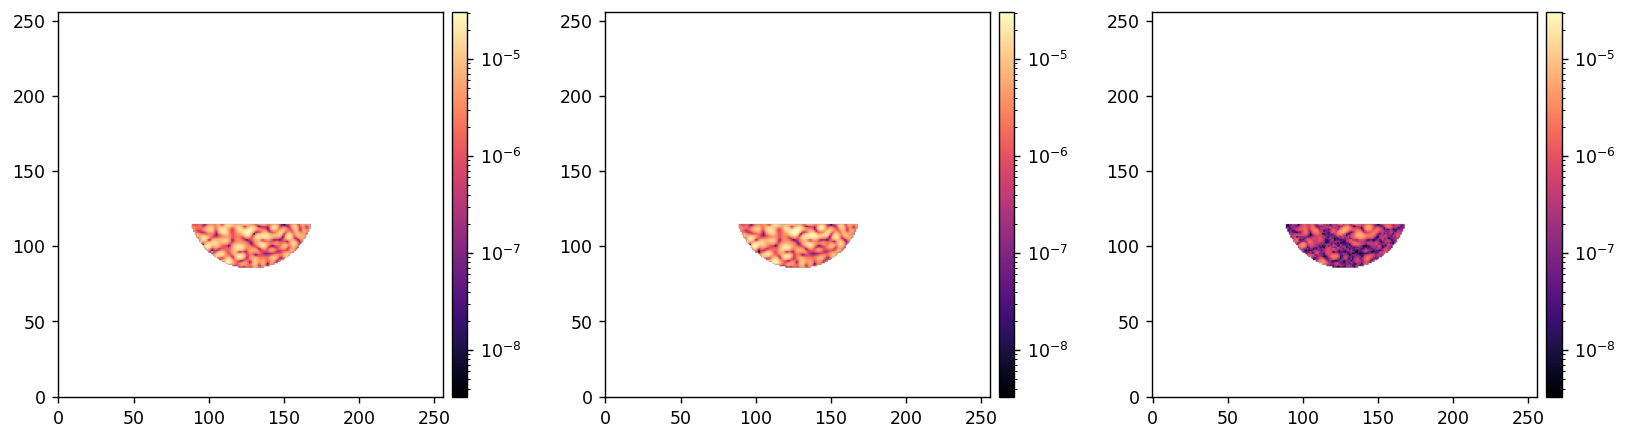

In [9]:
I_pwp = xp.abs(xp.array(E_est**2))
I_diff = xp.array(coro_im_ni0*dh_mask) - I_pwp
utils.imshow(
    [coro_im_ni0*dh_mask, I_pwp, xp.abs(I_diff)], 
    norms=[LogNorm()]*3,
    # 'Reference Image', 'Estimated Intesnity', 'Difference',
    # lognorm1=True, lognorm2=True, 
    # vmin1=vmin, vmin2=vmin, 
    # lognorm3=True, vmin3=vmin,
)

# Now run aEFC and PWP together end-to-end.

In [10]:
DM2_STREAM.write(np.zeros_like(ensure_np_array(M.dm_mask)))
efc_data = {
    'images':[coro_im_ni0],
    'contrasts':[contrast0],
    'efields':[],
    'commands':[],
    'del_commands':[],
    'reg_conds':[],
    'pixelscale':M.camsci_pxscl_lamDc,
    'control_mask':dh_mask, 
}

In [11]:

cm20 = utils.beta_reg(jac, -2, return_np=0)
cm25 = utils.beta_reg(jac, -2.5, return_np=0)
cm30 = utils.beta_reg(jac, -3, return_np=0)
cm35 = utils.beta_reg(jac, -3.5, return_np=0)
cm40 = utils.beta_reg(jac, -4, return_np=0)
cm45 = utils.beta_reg(jac, -4.5, return_np=0)
cm50 = utils.beta_reg(jac, -5, return_np=0)

In [29]:
cm25.shape

(952, 3438)

In [41]:
type(cm25)

cupy.ndarray

Running iteration 1


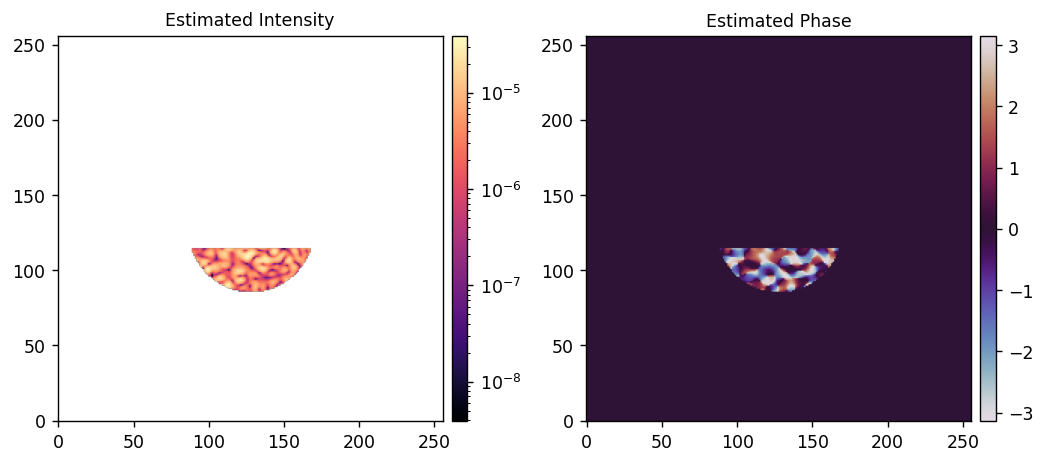

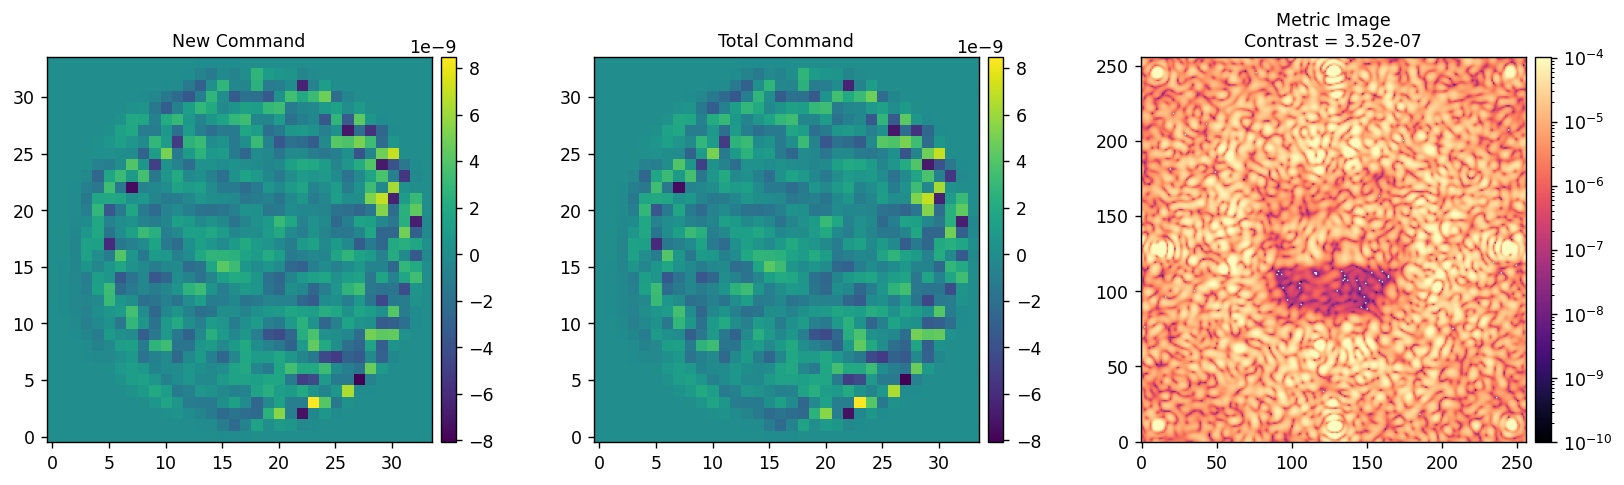

Running iteration 2


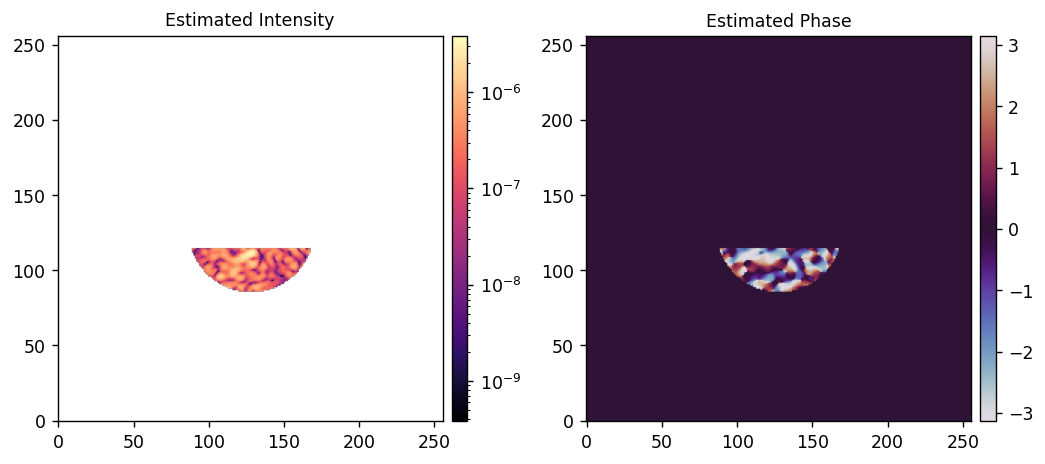

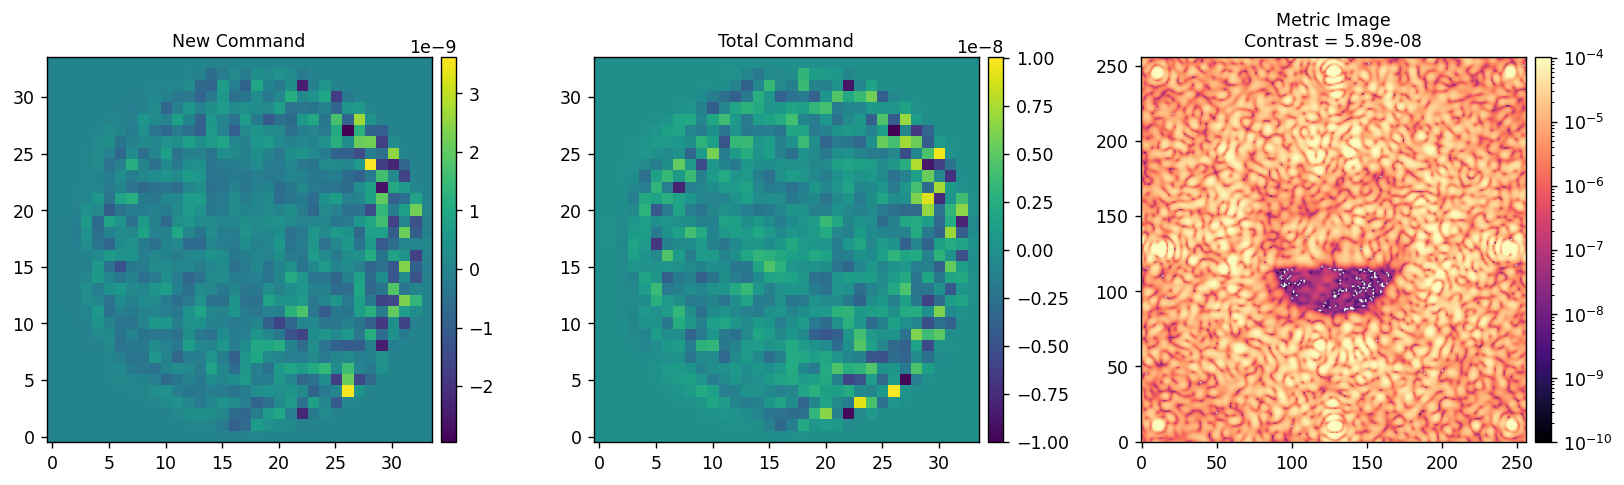

In [12]:
reload(efc)
reload(pwp)

pwp_params = {
    'NFRAMES':10,
    'jacobian':jac,
    'control_mask':dh_mask, 
    'dm_mask':dm_mask,
    'probes':fourier_probes,
    'probe_amp':2.5e-9,
    'reg_cond':1e-2,
    'reg_cond':1e-3,
    # 'reg_cond':1e-4,
    'gain':1,
    'plot_est':True,
}

efc_data = efc.run(
    efc_data,
    CAMSCI_STREAM,
    DM2_STREAM, 
    coro_im_params,
    ref_params,
    10,
    coro_dark,
    dh_mask,
    dm_mask,
    cm25,
    # cm50,
    pwp_params=pwp_params,
    Nitr=2, 
    gain=1, 
    leakage=0.0, 
)

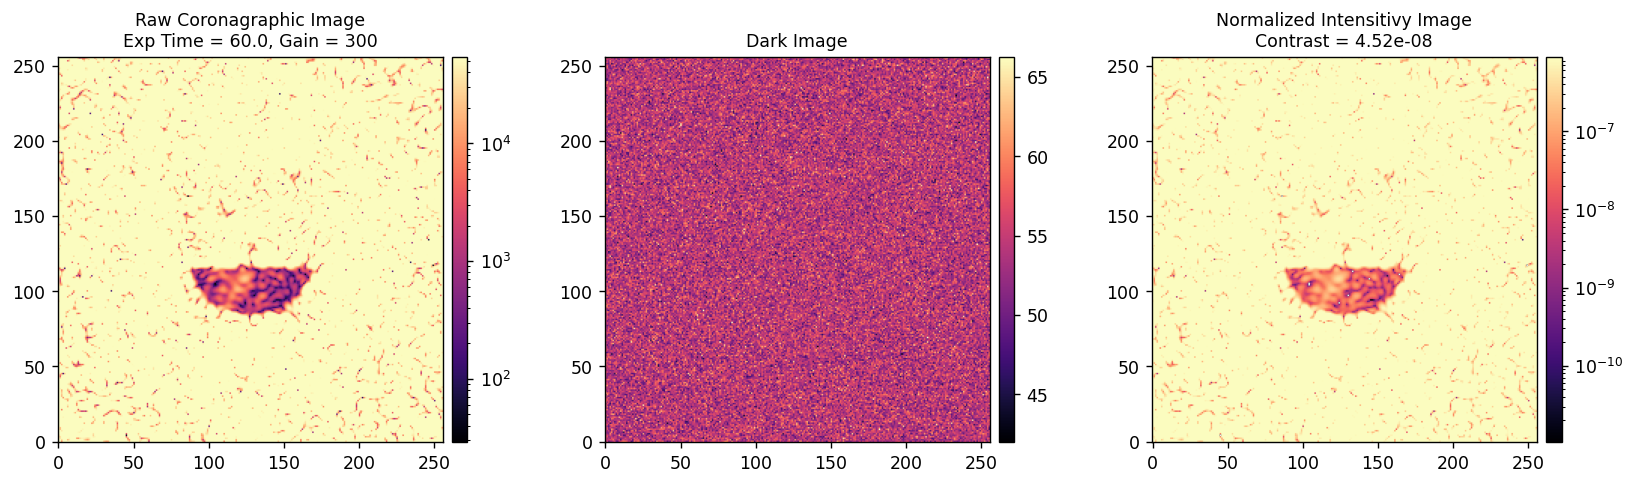

In [ ]:

coro_im_params = {
    'exp_time':60.0,
    'gain':300,
}

shmim_utils.write(CAMSCI_EXPTIME_STREAM, [coro_im_params['exp_time']])
shmim_utils.write(CAMSCI_GAIN_STREAM, [coro_im_params['gain']])

shmim_utils.write(CAMSCI_SHUTTER_STREAM, [1])
time.sleep(0.5)
coro_dark = shmim_utils.stack(CAMSCI_STREAM, 200)
shmim_utils.write(CAMSCI_SHUTTER_STREAM, [0])

coro_im = shmim_utils.stack(CAMSCI_STREAM, 10)
coro_im_ni = coro_utils.normalize_coro_im(coro_im, coro_im_params, ref_params, coro_dark)

contrast = coro_utils.compute_contrast(coro_im_ni, dh_mask)

utils.imshow(
    [coro_im, coro_dark, coro_im_ni],
    titles=[
        f'Raw Coronagraphic Image\nExp Time = {coro_im_params["exp_time"]}, Gain = {coro_im_params["gain"]}', 
        f'Dark Image',
        f'Normalized Intensitivy Image\nContrast = {contrast:.2e}',
    ],
    norms=[LogNorm(), None, LogNorm()],
)